# **L'importation des Bibliotheques**

In [1]:
!pip install yfinance --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats
from scipy.optimize import minimize
import yfinance as yf
import datetime
from IPython.display import display, Latex
plt.style.use('dark_background')

## Discrétisation d’Euler du processus d’Ornstein-Uhlenbeck

${\LARGE \Delta x_{t+1} = \theta (\mu - x_t)\,\Delta t + \sigma \sqrt{\Delta t} \cdot \epsilon_t}$

### Définition des termes :
- ${x_t}$ : valeur du processus à l’instant $t$
- ${\theta}$ : vitesse de retour à la moyenne *(mean reversion rate)*
- ${\mu}$ : moyenne de long terme
- ${\sigma}$ : écart-type du bruit *(volatilité)*
- ${\Delta t}$ : pas de temps (ex. ${\frac{1}{252}}$ pour un pas journalier)
- ${\epsilon_t \sim \mathcal{N}(0,1)}$ : bruit blanc gaussien

---

### Forme explicite équivalente :

${\huge x_{t+1} = x_t + \theta(\mu - x_t)\Delta t + \sigma \sqrt{\Delta t} \cdot \epsilon_t}$

C’est une discrétisation d’Euler de :

${\Huge dX_t = \theta(\mu - X_t)\,dt + \sigma\,dW_t}$



In [3]:
def simulate_ou_process(X0, T, dt, theta, mu, sigma, M, seed=False):
    """
    Simule un processus d'Ornstein-Uhlenbeck.

    Paramètres :
        X0 : valeur initiale
        total_time : durée totale de la simulation
        time_step : taille du pas de temps
        theta : vitesse de retour vers la moyenne
        mu : moyenne long terme
        sigma : volatilité
        num_paths : nombre de trajectoires simulées
        seed : booléen pour fixer la graine (reproductibilité)

    Retour :
        t : vecteur temps
        X : matrice des trajectoires simulées (shape = num_paths x len(t))
    """
    N = int(T / dt)
    t = np.arange(0, T, dt)
    X = np.zeros((M, N))
    X[:, 0] = X0

    if seed:
        np.random.seed(42)

    for i in range(1, N):
        X[:, i] = X[:, i - 1] + theta * (
            mu - X[:, i - 1]
        ) * dt + sigma * np.sqrt(dt) * np.random.normal(size=M)

    return t, X

In [4]:
def plot_ou_simulation(t, X):
    # Forcer un style clair
    plt.style.use('default')  # ou 'seaborn-whitegrid' pour un fond blanc avec grille

    fig, ax = plt.subplots(facecolor='white')  # fond blanc de la figure
    fig.patch.set_facecolor('white')  # sécurité en plus

    for j in range(X.shape[0]):
        ax.plot(t, X[j], color='red')  # tracer en rouge

    ax.set_facecolor('white')  # fond blanc de la zone de tracé
    ax.set_title("Simulation du Processus d'Ornstein-Uhlenbeck")
    ax.set_xlabel("Temps")
    ax.set_ylabel("Valeur")
    ax.grid(True)

    plt.show()


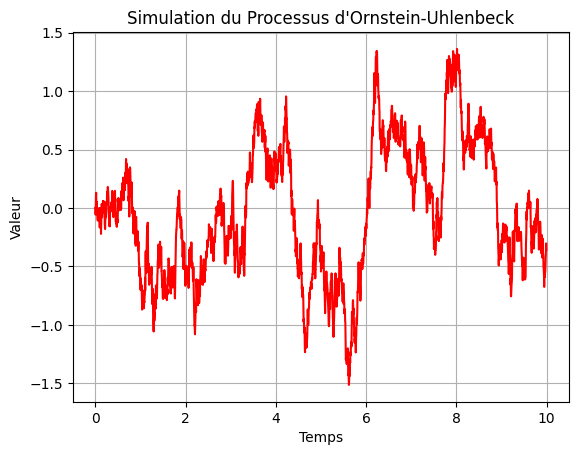

In [5]:
theta = 1
mu = 0
sigma = 1
X0 = 0
T = 10
dt = 1 / 252
M = 1

t, X = simulate_ou_process(X0, T, dt, theta, mu, sigma, M)
plot_ou_simulation(t, X)

### Estimation du Maximum de Vraisemblance (EMV)

La méthode de **Maximum de Vraisemblance** (EMV) permet d'estimer les paramètres d'une distribution probabiliste en maximisant la probabilité d'observer les données. Nous allons l'appliquer à une **loi normale**.

---

#### 1. Fonction de densité de probabilité (loi normale)
Pour une variable aléatoire \( X \sim \mathcal{N}(\mu, \sigma^2) \), la densité est :

$$
f_\theta(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
$$

- \(\mu\) : moyenne  
- \(\sigma^2\) : variance  
- \(x\) : observation  

---

#### 2. Fonction de vraisemblance
Pour $n$ observations indépendantes $x_1, \dots, x_n$, la vraisemblance est :

$$
L(\theta \mid x) = \prod_{i=1}^n f_\theta(x_i)
$$

où $\theta = (\mu, \sigma^2)$.
---

#### 3. Maximisation de la vraisemblance
On cherche $\hat{\theta}(x)$ qui maximise $L(\theta \mid x)$. On utilise la **log-vraisemblance** :

$$
\log L(\theta \mid x) = \sum_{i=1}^n \log f_\theta(x_i)
$$
---

#### 4. Estimateurs EMV

##### Pour $\mu$  :
Dérivée par rapport à $\mu$ :

$$
\frac{\partial}{\partial \mu} \log L(\theta \mid x) = \sum_{i=1}^n \frac{x_i - \mu}{\sigma^2} = 0 \quad \Rightarrow \quad \hat{\mu} = \frac{1}{n} \sum_{i=1}^n x_i
$$

##### Pour $\sigma^2$ :
Dérivée par rapport à $\sigma^2$ :


$$
\frac{\partial}{\partial \sigma^2} \log L(\theta \mid x) = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} \sum_{i=1}^n (x_i - \mu)^2 = 0 \quad \Rightarrow \quad \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2
$$

---

### 5. Conclusion
Les estimateurs EMV pour une loi normale sont :

- **Moyenne** : $\hat{\mu} = \frac{1}{n} \sum_{i=1}^n x_i$  
- **Variance** : $\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2$

In [6]:
def plot_normal_distribution(mu=0, sigma=1, num_points=100, estimate=False):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, num_points)
    y = stats.norm.pdf(x, loc=mu, scale=sigma)
    mu_rounded = round(mu, 4)
    sigma_rounded = round(sigma, 4)
    plt.plot(x, y, 'r', label=f'$\mu={mu_rounded}$, $\sigma={sigma_rounded}$' if not estimate else f'$\hat\mu={mu_rounded}$, $\hat\sigma={sigma_rounded}$')
    plt.title("Distribution Normale")
    plt.xlabel("Ecarts-Type")
    plt.ylabel("Densité")
    plt.legend()
    plt.gcf().set_facecolor('white')
    plt.show()

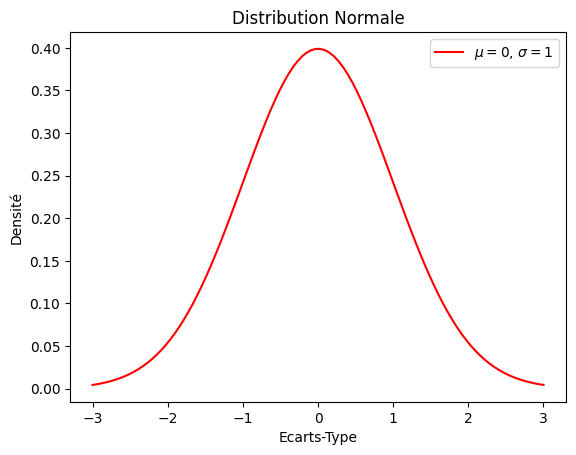

In [7]:
plot_normal_distribution()

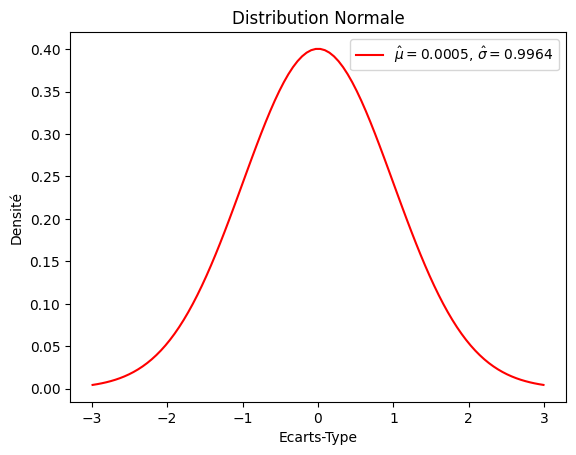

In [8]:
N = 80000
X = np.random.normal(loc=0, scale=1, size=N)

# Estimation de la moyenne et de l'écart-type
mu_estimate = X.mean()
sigma_estimate = X.std()

# Tracer la distribution normale avec les estimations
plot_normal_distribution(mu_estimate, sigma_estimate, estimate=True)

### Trouver la fonction de densité du processus d'Ornstein-Uhlenbeck

Trouver l'équation pour $d(X_t)$ avec le calcul d'Itô puis déterminer l'espérance et la variance de $X_t$.

Trouver la dynamique de $X_t$

- ${\Large dX_{t}=\theta (\mu -X_{t})\,dt+\sigma \,dW_{t}}$
- $\Large dX_t= \theta \mu dt -\theta X_t dt+\sigma dW_t$
- $\Large dX_t + \theta X_t dt = \theta \mu dt + \sigma dW_t$

- $\int^T_0 d(e^{\theta t} X_t) = \int^T_0 \theta \mu e^{\theta t} dt + \int^T_0 \sigma e^{\theta t} dW_t$
- $ e^{\theta T} X_T - X_0 = \theta \mu \frac{e^{\theta T}-1}{\theta} + \sigma \int^T_0 e^{\theta t} dW_t$
- $ X_T = X_0 e^{-\theta T} + \mu (1 - e^{-\theta T}) + \sigma \int^T_0 e^{-\theta (T-t)} dW_t$

Trouver l'espérance $E[X_T]$

- $E[X_T] = E[X_0 e^{-\theta T} + \mu (1 - e^{-\theta T}) + \sigma \int^T_0 e^{-\theta (T-t)} dW_t]$
- $E[X_T] = X_0 e^{-\theta T} + \mu (1 - e^{-\theta T})$

Trouver la variance $Var[X_T] = E[(X_T- E[X_T])^2]$.
- $Var[X_T] = E[(\sigma \int^T_0 e^{-\theta (T-t)} dW_t)^2]$
- $Var[X_T] = \sigma^2 \int^T_0 e^{-2\theta (T-t)} dt$
- $Var[X_T] = \sigma^2 \frac{1-e^{-2\theta T}}{2 \theta}$
- $Var[X_T] = \frac{\sigma^2}{2 \theta}(1-e^{-2\theta T}) $

Distribution normale du processus avec l'espérance $E[X_t]$ et la variance $Var[X_t]$.
- $\Large X_t \sim N(\mu, \sigma)$
- $\Large X_t = \mu + \sigma  Z_t$

- $\LARGE X_{t+\Delta t} = X_t e^{-\theta T} + \mu (1 - e^{-\theta T}) + \sigma \sqrt{\frac{(1-e^{-2\theta T})}{2 \theta}} N(0,1)$

### EMV du Processus d'Ornstein-Uhlenbeck
- $\Large X_t \sim N(\overline\mu, \overline{\sigma})$
- $\Large E[X_{t+\delta t}] = X_t e^{-\theta \delta t} + \mu (1 - e^{-\theta \delta t})$
- $\Large Var[X_{t+\delta t}] = \frac{\sigma^2}{2 \theta}(1-e^{-2\theta \delta t}) $

 $\Large f_\overline{\theta} (x_{t+\delta t} | x_t, \theta, \mu, \sigma)=\frac{1}{\sqrt{2\pi \overline{\sigma}^2}} e^{\frac{-(x-\overline\mu)^2}{2 \overline{\sigma}^2}}$

$\Large \overline\mu(x_t, \theta, \mu) = x_t e^{-\theta \delta t} + \mu (1 - e^{-\theta \delta t})$

In [9]:
def _mu(x, dt, theta, mu):
    ett = np.exp(-theta * dt)
    return x * ett + mu * (1 - ett)

$\Large \overline{\sigma}(\theta, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\theta \delta t})}{2 \theta}}$

In [10]:
def _sigma(dt, theta, sigma):
    e2tt = np.exp(-2 * theta * dt)
    return sigma * np.sqrt((1 - e2tt) / (2 * theta))

Fonction de log-vraisemblance :

$\Large l(\theta) = \sum^N_{i=1} log f_\theta (x_i)$

In [11]:
def log_likelihood(theta_estimate, x, dt=1 / 252):
    theta = theta_estimate[0]
    mu = theta_estimate[1]
    sigma = theta_estimate[2]

    x_dt = x[1:]
    x_t = x[:-1]

    mu_OU = _mu(x_t, dt, theta, mu)
    sigma_OU = _sigma(dt, theta, sigma)

    l_theta_estimate = np.sum(
        np.log(stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU))
    )

    return -l_theta_estimate

In [12]:
def theta_pos(theta_estimate):
    return theta_estimate[0]


def sigma_pos(theta_estimate):
    return theta_estimate[2]


def optimize_ou_parameters(data, theta0=[1, 1, 1]):
    constraints = [
        {
            'type': 'ineq',
            'fun': theta_pos
        }, {
            'type': 'ineq',
            'fun': sigma_pos
        }
    ]
    return minimize(
        fun=log_likelihood, x0=theta0, args=(data, ), constraints=constraints
    )

In [13]:
def estimate_ou_parameters(data, theta0=[1, 1, 1]):

    optimize = optimize_ou_parameters(data, theta0)

    theta = round(optimize.x[0], 3)
    mu = round(optimize.x[1], 3)
    sigma = round(optimize.x[2], 3)

    theta_estimate_ = f'$\Large\\hat{{\\theta}} = {theta}$'
    mu_estimate_ = f'$\Large\\hat{{\\mu}} = {mu}$'
    sigma_estimate_ = f'$\Large\\hat{{\\sigma}} = {sigma}$'

    display(Latex(theta_estimate_))
    display(Latex(mu_estimate_))
    display(Latex(sigma_estimate_))

    return theta, mu, sigma

In [14]:
import yfinance as yf
import datetime
import pandas as pd

# Définir les dates
start_date = '2005-01-01'  # Date de départ fixe
end_date = datetime.datetime.now().strftime('%Y-%m-%d')  # Aujourd'hui

# Télécharger les données
try:
    # Solution 1 (recommandée): Téléchargement direct avec les dates en string
    prices_ohlc = yf.download('SPY', start=start_date, end=end_date)

    # Alternative si problème: Téléchargement par périodes
    if len(prices_ohlc) == 0:
        print("Tentative alternative avec téléchargement par périodes...")
        data = yf.Ticker("SPY")
        prices_ohlc = data.history(period="max")  # Depuis la date de création (1993)
        prices_ohlc = prices_ohlc.loc[start_date:end_date]

    # Vérification des données
    print(f"Données récupérées du {prices_ohlc.index[0].date()} au {prices_ohlc.index[-1].date()}")
    print(prices_ohlc.head(3))

except Exception as e:
    print(f"Erreur : {str(e)}")
    print("Conseils de dépannage :")
    print("1. Vérifiez votre connexion Internet")
    print("2. Essayez un autre ticker comme '^GSPC' ou 'VOO'")
    print("3. Essayez avec une période plus courte pour tester")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Données récupérées du 2005-01-03 au 2025-05-08
Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2005-01-03  82.316650  83.315671  82.042945  83.178816  55748000
2005-01-04  81.310791  82.480877  81.043929  82.426135  69167600
2005-01-05  80.749748  81.598232  80.742904  81.249256  65667300


Text(0.5, 1.0, 'Volatilité S&P 500')

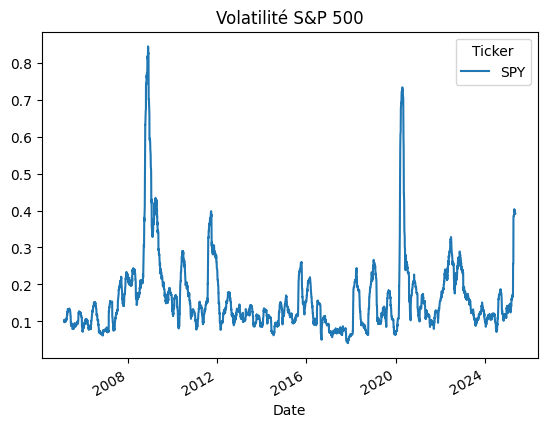

In [15]:
sp_log_returns = np.log(prices_ohlc.Close / prices_ohlc.Close.shift(1)).dropna()

sp_volatility = (sp_log_returns.rolling(window=40).std() *
                 np.sqrt(252)).dropna()

sp_volatility.plot()
plt.title('Volatilité S&P 500')

In [49]:
theta, mu, sigma = estimate_ou_parameters(sp_volatility, [0.9, 0.5, 0.7])

<ipython-input-11-83c7d0f39b7b>:13: RuntimeWarning: divide by zero encountered in log
  np.log(stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-10-1955b74c880a>:3: RuntimeWarning: invalid value encountered in scalar divide
  return sigma * np.sqrt((1 - e2tt) / (2 * theta))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [50]:
def simulate_continuous_ou_process(X0, T, theta, mu, sigma, M):
    Z = np.random.normal(size=(M))
    drift_OU = _mu(X0, T, theta, mu)
    diffusion_OU = _sigma(T, theta, sigma)
    result = drift_OU + diffusion_OU * Z

    # Replace inf and nan with finite values
    result = np.nan_to_num(result, nan=0.0, posinf=np.finfo(float).max, neginf=np.finfo(float).min)

    return result

In [51]:
def plot_kde(data, title="Titre", xlabel="x", ylabel="y"):
    # Remove inf and nan values from data
    data = data[np.isfinite(data)]

    if len(data) == 0:
        print("Warning: No valid data points for KDE plot.")
        return  # Exit the function if no valid data

    kde = stats.gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    kde_vals = kde(x_vals)
    mode_peak = x_vals[np.argmax(kde_vals)]

    sns.kdeplot(data, shade=True)
    plt.axvline(mode_peak, linestyle='--', label=f'Mode: {mode_peak:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

<ipython-input-51-25e3123d8747>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


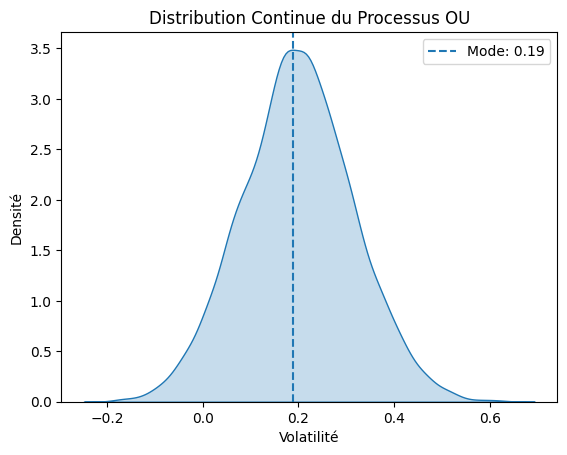

In [52]:
T = 8
M = 10000
# Get the last valid value from the 'sp_volatility' Series using .iloc
X0 = sp_volatility.iloc[-1, 0]  # Access the value in the single column

# X0 is already a single numeric value, no need to reshape.
# Remove the line: X0 = X0.values.reshape(-1)

simulated_data = simulate_continuous_ou_process(X0, T, theta, mu, sigma, M)

# Ensure simulated_data has at least some variance
if np.var(simulated_data) < 1e-6:
    simulated_data = simulated_data + np.random.normal(scale=1e-3, size=simulated_data.shape) # Add a small noise to simulated data to add variance

plot_kde(
    simulated_data,
    title="Distribution Continue du Processus OU",
    xlabel="Volatilité",
    ylabel="Densité"
)

In [53]:
def simulate_and_compare_data(
    data, theta, mu, sigma, start_date, M=1, seed=False
):
    T = len(data) / 252
    dt = 1 / 252

    t, OU = simulate_ou_process(data.iloc[0, 0], T, dt, theta, mu, sigma, M, seed=seed)
    OU = OU[0]

    time_index = pd.date_range(start=start_date, periods=len(data),
                               freq='B')[-len(OU):]

    min_length = min(len(OU), len(data[-len(OU):]))
    OU = OU[:min_length]
    array = data[-min_length:]
    time_index = time_index[:min_length]

    def compare_statistics(real_data, simulated_data):
        stats_comparison = {
            "Moyenne": (np.mean(real_data), np.mean(simulated_data)),
            "Écart-type": (np.std(real_data), np.std(simulated_data)),
            "Skewness": (stats.skew(real_data), stats.skew(simulated_data)),
            "Kurtosis":
                (stats.kurtosis(real_data), stats.kurtosis(simulated_data))
        }
        return pd.DataFrame(
            stats_comparison, index=["Données Réelles", "Processus OU"]
        )

    print(compare_statistics(array, OU))

    plt.figure(figsize=(10, 6))
    plt.plot(time_index, OU, label="Processus OU")
    plt.plot(time_index, array, label="Données Réelles", alpha=0.7)
    plt.title("Processus OU et Données Réelles")
    plt.xlabel("Date")
    plt.ylabel("Valeur")
    plt.legend()

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


                  Moyenne                            Écart-type  \
Données Réelles  0.161020  Ticker
SPY    0.10557
dtype: float64   
Processus OU     0.143329                              0.092635   

                             Skewness              Kurtosis  
Données Réelles  [3.1564116201917143]  [13.182842217952388]  
Processus OU                -0.135742              0.098451  


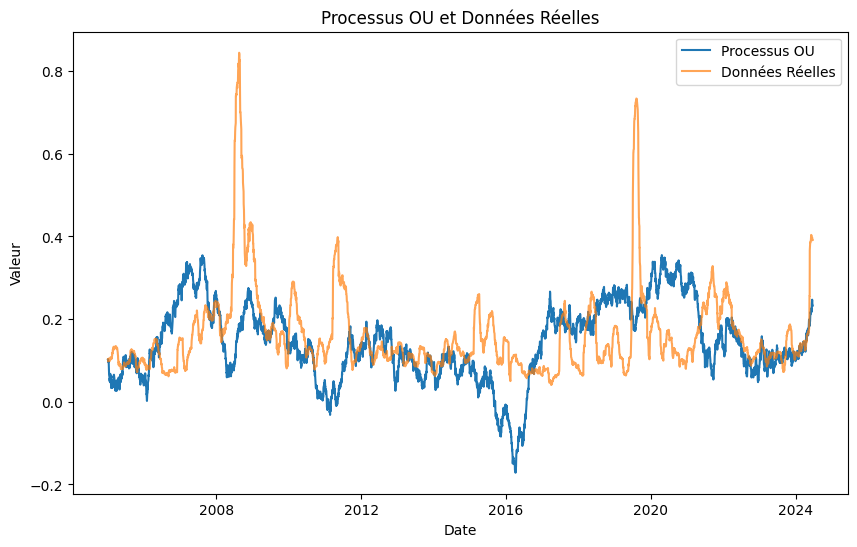

In [54]:
simulate_and_compare_data(sp_volatility, theta, mu, sigma, start_date)

In [55]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=7300)

prices_ohlc = yf.download('EURUSD=X', start=start_date, end=end_date)
eurusd_close = prices_ohlc['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


In [120]:
theta, mu, sigma = estimate_ou_parameters(eurusd_close, [1.7, 0.82, 0.92])

<ipython-input-11-83c7d0f39b7b>:13: RuntimeWarning: divide by zero encountered in log
  np.log(stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<ipython-input-51-25e3123d8747>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


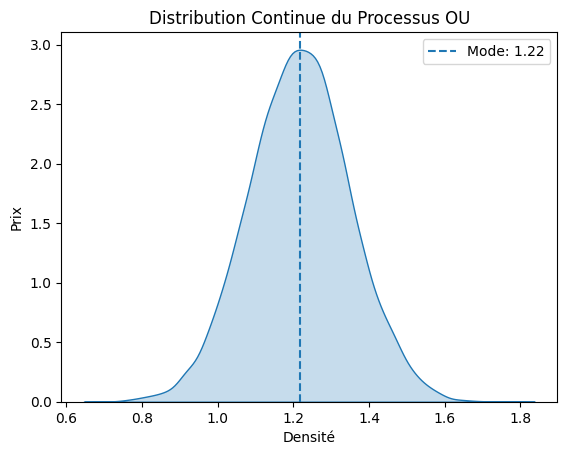

In [123]:
Time = 10
M = 10000
# Access the second element using .iloc
X0 = eurusd_close.iloc[1]

# If eurusd_close has only one column, you can access the value directly
X0 = X0.values[0] if isinstance(X0, pd.Series) else X0

simulated_data = simulate_continuous_ou_process(X0, Time, theta, mu, sigma, M)
plot_kde(
    simulated_data,
    title="Distribution Continue du Processus OU",
    xlabel="Densité",
    ylabel="Prix"
)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


                  Moyenne                                 Écart-type  \
Données Réelles  1.224525  Ticker
EURUSD=X    0.13243
dtype: float64   
Processus OU     1.202216                                   0.132177   

                              Skewness               Kurtosis  
Données Réelles  [0.48926191490368476]  [-0.6077695820924425]  
Processus OU                  0.364389               -0.20161  


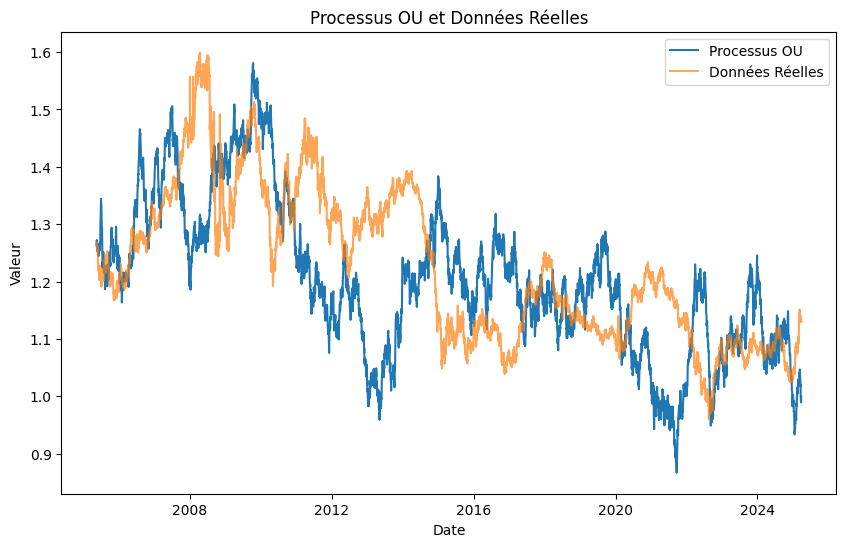

In [124]:
simulate_and_compare_data(eurusd_close, theta, mu, sigma, start_date)